Code for analysisa nd fgures use din figures 5+, autoencoder and DB index generation
#### Description

#### Run Order


In [1]:
from pathlib import Path

import sys
import os
import notebook_setup
info = notebook_setup.setup()
# Environment & Imports Setup
import matplotlib as matplotlib
#code ocean step
use_code_ocean = True
if use_code_ocean:
    matplotlib.use('Agg')
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import davies_bouldin_score
import warnings
import numpy as np
import random
%matplotlib inline 
print(f"matplotlib {matplotlib.__version__} | Seaborn {sns.__version__}")
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', False) # pd.set_option('future.no_silent_downcasting', True)
np.random.seed(1) #set seed for reproducibility 
random.seed(1)
# Apply mplstyle via absolute path from setup info
style_path = Path(info["function_py_storage"]) / "paper_plot.mplstyle"
print(f"Loading style guide at {style_path}")
if style_path.is_file():
    plt.style.use(str(style_path))
else:
    print(f"[warn] Style not found at: {style_path}")
here = info["repo_root"]
print(f" Here: {here}")
_plot_posthoc_src = os.path.join(here, 'plot_posthoc_test', 'src')
if os.path.isdir(_plot_posthoc_src) and _plot_posthoc_src not in sys.path:
    sys.path.append(_plot_posthoc_src)

#custom function import
import custom_module_imports as cmi 
from preprocess_data import hyper_param_dict
from helper_functions import save_fig_in_main_fig_dir,  save_plot_record_as_csv_txt 
from ax_modifier_functions import set_ax_title_xlabel_ylabel, set_pointplot_edgecolor, set_labels
from sns_plotting_config import * #import dicts containing default plot params
from plot_posthoc_test.plot_stat_annotate import *
date_tag = "_".join([datetime.now().strftime('%d'),datetime.now().strftime('%h'),datetime.now().strftime('%Y')])
##Set/create save and load folder paths 
results_location = Path(here).parents[0] / "results"
data_location = Path(here).parents[0] / "data"
make_folder(results_location)
make_folder(data_location)
print(f"Saving results in {results_location}. Data location is {data_location}")
csv_folder_most_recent = results_location/ f"analysis_CSV_output/" #folders that analysis output goes to
make_folder( csv_folder_most_recent)

matplotlib 3.7.0 | Seaborn 0.12.1
Loading style guide at C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\paper_plot.mplstyle
 Here: C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\data' already exists.
Saving results in C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results. Data location is C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\data
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output' already exists.


<Figure size 960x720 with 0 Axes>

## Process Data 


In [2]:
trial_df_filename = data_location /  f"Dlx56_Normalized Trial Calcium Timeseries_20_Jun_2025.parquet"
trial_tseries_df_norm = pd.read_parquet(trial_df_filename)
#once loaded, derive info from metadata
stage_names = sorted(trial_tseries_df_norm['task_phase_vec'].unique())#hardcode the stage_names (to not rely on the order of the 'unique() vector of the df
numeric_col = cmi.pp.get_numeric_cols_timeseries(trial_tseries_df_norm, " to ") #in external_functions.py
# note informative stats for refernce later if necessary
subject_stage_info_df = cmi.pp.get_subject_stage_info_df(trial_tseries_df_norm) # get subj level dfs
n_total_units = trial_tseries_df_norm.groupby(by = 'geno_day')['unique_ID'].nunique()
print(n_total_units)
subject_stage_info_df.tail(3)

geno_day
Het CLNZ         866
Het VEH          874
Het postCLNZ     937
WT CLNZ         1019
WT VEH          1080
Name: unique_ID, dtype: int64


,name,geno_day,task_phase_vec,unique_ID,num_enriched_units,num_units,trial_num,count_of_trials,over_5
200,9_3_HET_RS3,Het postCLNZ,Early_RS_Error,"[9_3_HET_RS3-25, 9_3_HET_RS3-45, 9_3_HET_RS3-6...",9,179,"[18, 20]",2,"[True, True]"
201,9_3_HET_RS3,Het postCLNZ,Late_IA,"[9_3_HET_RS3-9, 9_3_HET_RS3-25, 9_3_HET_RS3-31...",15,179,"[12, 13, 14, 15, 16]",5,"[True, True, True, True, True]"
202,9_3_HET_RS3,Het postCLNZ,Late_RS,"[9_3_HET_RS3-3, 9_3_HET_RS3-130]",2,179,"[34, 35, 36, 38]",4,"[True, True, True, True]"


In [3]:
last_bootstrap_run = data_location / "NN 1000 bootstrap_ DB index results_24_Jun_2025.parquet"
#set parameters 
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                              'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                              'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                              'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
geno_plot = geno_order_w_WT_CLNZ
bootstrap_output =pd.read_parquet(last_bootstrap_run)
print(bootstrap_output.info())
bootstrap_output.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 9
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model_run     40000 non-null  int64  
 1   DB_index      40000 non-null  float64
 2   n_epochs      40000 non-null  int64  
 3   final_loss    40000 non-null  float64
 4   ensemble      40000 non-null  object 
 5   geno_day      40000 non-null  object 
 6   comparison    40000 non-null  object 
 7   lossDelta     40000 non-null  float64
 8   class_1_mean  40000 non-null  float64
 9   class_2_mean  40000 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.4+ MB
None


,model_run,DB_index,n_epochs,final_loss,ensemble,geno_day,comparison,lossDelta,class_1_mean,class_2_mean
0,0,0.569982,50,0.058213,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0534,0.1263,0.0378
1,1,0.530064,50,0.058002,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0679,0.1262,0.0377
2,2,0.536322,50,0.058013,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0626,0.1263,0.0380


In [4]:
ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error'] #what ensembles do you care about
geno_plot =  geno_order_w_WT_CLNZ
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error'] #what class comparisons do you care about


## Bootstrap density score- embedded

In [5]:
#2 datasets: 1: sample embedding for viz, 2: bootstrap DB index over 1000
#1) latent_embed_sample used for visualization
autoencode_filename = data_location/  "Autoencoder_latent_space_28_Jun_2025_500Sample.parquet"
embed_record =pd.read_parquet(autoencode_filename)
latent_embed_sample = embed_record
latent_embed_sample.sample()

,embed_1,embed_2,labels,classes_decoded,geno_day,ensemble,class_0,class_1,n_frames,num_epochs,mean_loss,n_cells,dropout,test_on_train,date_run
456,0.340589,-0.706696,Late_IA,Late_IA_v_Early_RS_Correct,Het VEH,Late_IA,Late_IA,Early_RS_Correct,94,50,0.058566,94,0.05,False,28_Jun_2025


In [6]:
#2) mean density is used for DB index of latent space 
last_bootstrap_run = data_location/ "NN 1000 bootstrap_ DB index results_24_Jun_2025.parquet"
bootstrap_output =pd.read_parquet(last_bootstrap_run)
mean_density = bootstrap_output.set_index(['comparison', 'ensemble'])
mean_density.sample()

,,model_run,DB_index,n_epochs,final_loss,geno_day,lossDelta,class_1_mean,class_2_mean
comparison,ensemble,,,,,,,,
Late_IA_v_Early_RS_Correct,Early_RS_Correct,21,0.833949,50,0.087328,Het VEH,0.0908,0.1067,0.1727


In [7]:
ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error']
geno_plot =  geno_order
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error']
unique_comparisons = list(set(mean_density.index.get_level_values('comparison')))
score_df = mean_density
score_type = 'Davies-Bouldin index'

In [8]:
def plot_db_index_by_ensemble(ax_array, comparison, ensemble_subset, score_df: pd.DataFrame, ylim = [0, 1.5],
                              score_type = 'DB_index',
                              **kwargs):
    """
    Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.
    Parameters:
    - ensemble_subset (list): List of ensemble identifiers to plot.
    - score_df (pd.DataFrame): DataFrame containing the scores.
    - comparison (str): Identifier for the comparison condition.
    - color_list (list): Colors for plotting.
    - geno_order (list): Order of genotypes for consistent plotting.
    - ax_array (array-like): Array of matplotlib axes to use for subplots.
    - preset_comparison_list (list): Pairs or groups for statistical comparison.
    Returns:
    - - posthoc_list (list): External list to store posthoc result DataFrames. 
    """
    fig_suptitle = f"{comparison.replace("_", " ").replace(" v ", " & ")}\n stage activity separation"  
    fig.suptitle(fig_suptitle, fontsize = 6)
    posthoc_list= []        
    for e,ensemble in enumerate(ensemble_subset):
        plot_ax = ax_array[e]
        print(store_type)
        plot_params = dict( data = score_df.loc[(comparison,ensemble),:], x = 'geno_day', y =score_type, 
                           palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params,**kwargs)
        ensemble_name = f"{ensemble.replace("_", " ")} ensemble"
        set_labels(ax =plot_ax, label_dict = {'title': ensemble_name,'xlabel': 'Genotype-treatment', 'legend_false': True, 'ylim': ylim})
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, preset_comparison_list, test_name = 'cohen_d',ax_var_is_hue=True,detect_error_bar = True).assign(comparison=comparison_name)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.03,offset_constant=0.02) 
        set_pointplot_edgecolor(plot_ax)
        posthoc_list.append(posthoc_df)
        #wrap xticks
        plot_ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in plot_ax.get_xticklabels()])
    return posthoc_list

def plot_db_index_geno_dodge(plot_ax, 
                            comparison,
                            ensemble_subset,
                            score_df: pd.DataFrame,
                            add_legend = False,
                            ylim:list = [0, 1.5],
                            score_type = 'DB_index',
                            geno_plot = geno_order,
                            **kwargs):
    """    Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.    Dodges within geno 
    Parameters:
    - ensemble_subset (list): List of ensemble identifiers to plot.
    - score_df (pd.DataFrame): DataFrame containing the scores.
    - comparison (str): Identifier for the comparison condition.
    - color_list (list): Colors for plotting.
    - geno_order (list): Order of genotypes for consistent plotting.
    - ax_array (array-like): Array of matplotlib axes to use for subplots.
    - preset_comparison_list (list): Pairs or groups for statistical comparison.
    Returns:
    - - posthoc_list (list): External list to store posthoc result DataFrames. 
    """
    #main fig
    default_plot_setting = dict(errwidth = 1.25,dodge = 0.45,errorbar = ('pi',75))
    plot_aesthetic = {**kwargs, **{k:v for k,v in default_plot_setting.items() if k not in kwargs}}
    
    plot_params = dict( data = score_df.reset_index("ensemble").loc[comparison,:], 
                       x = 'ensemble', y =score_type, 
                       linestyles= 'none',
                       order = ensemble_subset,  
                      **plot_aesthetic,
                        **{True:geno_order_w_WT_CLNZ_no_eb, False:geno_color_dict_no_errorbar}["WT CLNZ" in geno_plot])
    
    sc = sns.pointplot(ax =plot_ax, **plot_params)
    #ax decorators
    fig_suptitle = f"{comparison.replace('_', ' ').replace(' v ', ' & ')}\n stage activity separation"
    set_labels(ax =plot_ax, label_dict = {'title': fig_suptitle, 'xlabel': 'Cell Ensemble', 'ylabel': 'Davies-Bouldin Index','legend_false': False, 'ylim': ylim})
    set_pointplot_edgecolor(plot_ax)
    ## plot stat annotate
    if "WT CLNZ" in plot_params['hue_order']:
        print(f"switching posthoc comparison to include WT CLNZ")
        comparison_list = comparison_list_w_WT_CLNZ
    else:
        comparison_list = preset_comparison_list
    posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list, test_name = 'cohen_d',ax_var_is_hue=False,
                                                           detect_error_bar = True,plot_type='pointplot').assign(comparison=comparison)
    plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.01) 
    add_xtick_color_boxes(plot_ax, ensemble_subset, stage_palette_dict)
    plot_ax.set_xticklabels(add_spaces_linebreak_to_stage_ticks(plot_ax.get_xticklabels()))
    if add_legend:
        hand, labs =plot_ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
        plt.gcf().legend(hand, labs, bbox_to_anchor=(0.55, .975),loc = 'lower center', ncols = 4, frameon = False, title =None,
         **{'labelspacing': 0.0, 'markerscale': 1, 'borderpad': 0.0,'columnspacing': 0.0, 'handletextpad': 0.0})
    return posthoc_df

def plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison,
                                 make_legend = True, samples_to_plot:int = 500, use_stage_colors= True, **kwargs):

    if use_stage_colors:
        scatter_palette=  [stage_palette_dict[s] for s in ensemble_subset]
    else: 
        scatter_palette=['red','blue']
    ##set default params for plots:
    plot_defaults = dict(alpha =.5, linewidth = 0.5)
    plot_kwargs = {**plot_defaults, **kwargs}
    comparison_clean = comparison.replace("_v_", " & ").replace("_", " ")
    for c_count, ensemble in enumerate(ensemble_subset):#Loop over all combinations    
        for g_count, g in enumerate(geno_order):    ##COL ITERATION
            plot_df = df_comparison.loc[(df_comparison[ens_col]== ensemble) & (df_comparison.geno == g),:].copy()
            legend_bool = {True: (g_count == len(geno_order)-1) & (c_count == len(ensemble_subset)-1),
                               False: False}[make_legend]
            ##optionally pull subset of cells
            input_data_index =np.arange(0, plot_df.shape[0]) 
            permuted_index =  np.random.default_rng().permutation(input_data_index)
            cell_subset = permuted_index[:samples_to_plot]
            plot_df = plot_df.iloc[cell_subset,:]
            #plot latent space  projection
            ax = ax_array[c_count,g_count]
            sns.scatterplot(data = plot_df,ax = ax, x= "embed_1", y= "embed_2", legend = legend_bool,
                            s= 3, hue_order = set(plot_df.labels.unique()),hue= 'labels', palette=scatter_palette, **plot_kwargs)
            #make ax mods
            for coll in ax.collections:
                coll.set_edgecolors(coll.get_facecolors().copy())# Restore the edge colors using the saved values
                coll.set_facecolors("none")# Remove the face color by setting it to "none"
            
            ax_title =  dict(label=f"{g}", pad = 2)
            set_ax_title_xlabel_ylabel(ax, label_dict = {'title': ax_title, 
                                                         'xlabel': 'Latent Dim. 1',
                                                         'ylabel': 'Latent Dim. 2',
                                                         'xticks':[], 'yticks':[] })    
    ##NEW- 5.9.25- add row title to latent space    #set titles for pseudo congig 
    row_titles = [f"Latent Space of {e.replace("_", " ")} Ensemble Activity" for e in ensemble_subset]
    add_ax_array_row_title(fig, row_titles, ax_array)
    
    if make_legend:#new- given removal of suptitle, now get text figure
        fig.canvas.draw() # force a draw so that the Text has a renderer
        renderer = fig.canvas.get_renderer()
        text_objs = [x for x in fig.get_children() if isinstance(x,matplotlib.text.Text)]
        bbox_fig = text_objs[0].get_window_extent(renderer).transformed(fig.transFigure.inverted()) # 3. get the bbox in display (pixel) coords
        hand, labels = ax_array.flat[-1].get_legend_handles_labels()
        ax_array.flat[-1].get_legend().remove() 
        legend_y = bbox_fig.y1 + 0.025
        fig.legend(handles = hand, labels = [x.replace("_", " ") for x in labels ], 
                   bbox_to_anchor=(.90, legend_y), loc = 'center right', frameon = False, title = None, ncol=2)   
    #last step, 
    for ax in ax_array.flat:# force each subplot’s BOX to be square:
        ax.set_box_aspect(1)
        ax.xaxis.labelpad= 2
        ax.yaxis.labelpad= 2

#### Figure 6E/F- Visualizing Latent space- IA v RS Correct 

In [9]:
latent_embed_sample = embed_record
##set latent space shared variables
compared_col = 'classes_decoded'
ens_col = 'ensemble'

The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_6' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_6\28_Aug_2025' already exists.


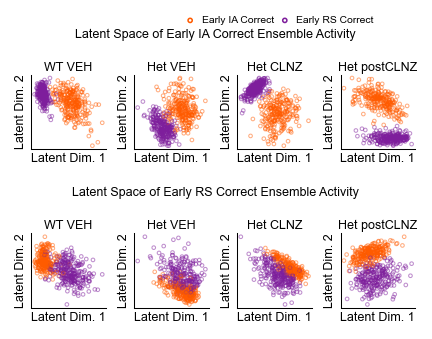

In [10]:
plot_df = latent_embed_sample.rename({'geno_day': 'geno'},axis = 1)
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
latent_space_figsize = (2.75,2)
latent_space_gridspec = dict(wspace = 0.1, hspace = 0.2)
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
fig_name = f"6_EF_Autoencoder projection- latent space- {comparison} ens"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=6, filetypes_to_save = ['png'])

#### Figure 6G: DB index of Early IA Correct & Early RS Correct

Saved 6_6_G_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\6_6_G_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_28_Aug_2025.txt
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_6' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_6\28_Aug_2025' already exists.


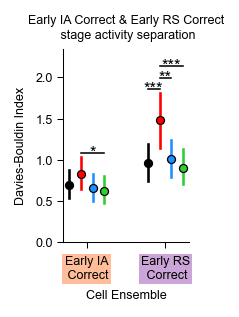

In [11]:
##subfig 2: DB index
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
db_index_fig_size = (1.25,2.)
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0, dodge = 0.45)
##save fig
fig_name = f"6_G_Autoencoder {comparison} DB index by ensembles"
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="6",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=6, filetypes_to_save = ['png'])

####  Figure 5F/G- Visualizing latent space- IA v RS Error

The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_5' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_5\28_Aug_2025' already exists.


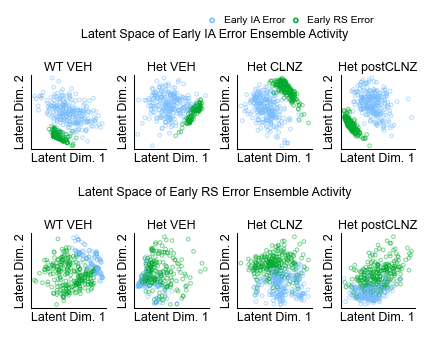

In [12]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize, layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
fig_name = f"5_FG_Autoencoder projection- latent space- {comparison} ens"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=5, filetypes_to_save = ['png'])

#### Figure 5H- Early IA Error & Early RS Error stage activity separation

The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_5' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_5\28_Aug_2025' already exists.
Saved 5_5_H_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\5_5_H_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_28_Aug_2025.txt


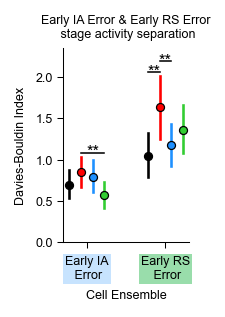

In [13]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize =db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
fig_name = f"5_H_Autoencoder {comparison} DB index by ensembles"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=5, filetypes_to_save = ['png'])
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="5",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

####  Figure 7H- DB index in latent space- Late IA v RS Correct

The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_7' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_7\28_Aug_2025' already exists.
Saved 7_7_H_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\7_7_H_Autoencoder Late_IA_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_28_Aug_2025.txt


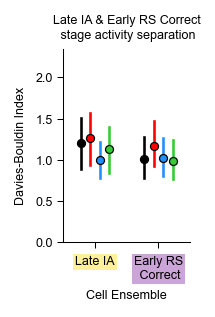

In [14]:
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
##save fig
fig_name = f"7_H_Autoencoder {comparison} DB index by ensembles"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=7, filetypes_to_save = ['png'])
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, None,csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

####  Figure 7D- DB index in latent space- Early IA Correct vs Late IA

The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_7' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\fig_7\28_Aug_2025' already exists.
Saved 7_7_D_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\7_7_D_Autoencoder Early_IA_Correct_v_Late_IA DB index by ensembles_posthoc_results_text_28_Aug_2025.txt


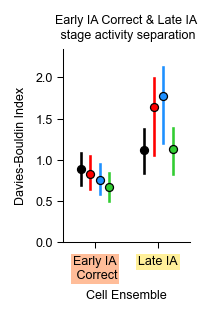

In [15]:
comparison = 'Early_IA_Correct_v_Late_IA'## get df of interest
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 2.35],scale = 1.0)
##save fig
fig_name = f"7_D_Autoencoder {comparison} DB index by ensembles"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=7, filetypes_to_save = ['png'])
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")  

#### Supplementary Figure 2I- Latent space separation of IA v RS Correct 

In [16]:
latent_embed_sample = embed_record
##set latent space shared variables
compared_col = 'classes_decoded'
ens_col = 'ensemble'
supp_figure_prefix = "supp_"

switching posthoc comparison to include WT CLNZ


Saved s_2_supp_2_I_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\s_2_supp_2_I_Autoencoder Early_IA_Correct_v_Early_RS_Correct DB index by ensembles_posthoc_results_text_28_Aug_2025.txt
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\supp_fig_2' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\supp_fig_2\28_Aug_2025' already exists.


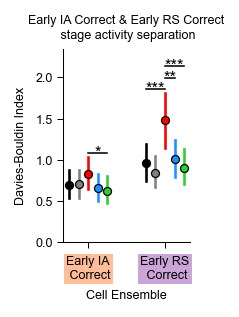

In [17]:
##subfig 2: DB index
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
db_index_fig_size = (1.25,2.)
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df, geno_plot = geno_order_w_WT_CLNZ, ylim = [0, 2.35],scale = 1.0,dodge = 0.5)
##save fig
fig_name = supp_figure_prefix+ f"2_I_Autoencoder {comparison} DB index by ensembles"
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="s_2",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])

#### Supplementary Figure 2G- latent space separation of IA v RS Error activity

switching posthoc comparison to include WT CLNZ


The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\supp_fig_2' already exists.
The folder 'C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\supp_fig_2\28_Aug_2025' already exists.
Saved s_2_supp_2_G_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc cohen d_28_Aug_2025.csv to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to C:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\s_2_supp_2_G_Autoencoder Early_IA_Error_v_Early_RS_Error DB index by ensembles_posthoc_results_text_28_Aug_2025.txt


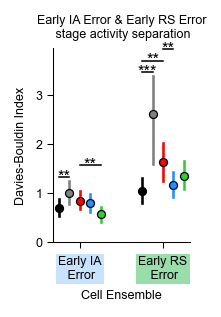

In [18]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize =db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,geno_plot = geno_order_w_WT_CLNZ,ylim = [0, 3.95],scale = 1.0,dodge = 0.5)
##save fig
fig_name =supp_figure_prefix+  f"2_G_Autoencoder {comparison} DB index by ensembles"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="s_2",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")